# COURSE: A deep understanding of deep learning
## SECTION: Overfitting, cross-validation, regularization
### LECTURE: Cross-validation -- manual separation
#### TEACHER: Mike X Cohen, sincxpress.com

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np


In [2]:
# import dataset (comes with seaborn)
import seaborn as sns

iris = sns.load_dataset("iris")


# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2


# Separate data into train and test

In [ ]:
#  (no devset here)

# how many training examples
propTraining = 0.8  # in proportion, not percent
nTraining = int(len(labels) * propTraining)

# initialize a boolean vector to select data and labels
traintestBool = np.zeros(len(labels), dtype=bool)

# is this the correct way to select samples?
# traintestBool[range(nTraining)] = True

# this is better, but why?
items2use4train = np.random.choice(range(len(labels)), nTraining, replace=False)
traintestBool[items2use4train] = True

traintestBool


In [4]:
# test whether it's balanced
print("Average of full data:")
print(torch.mean(labels.float()))  # =1 by definition
print(" ")

print("Average of training data:")
print(torch.mean(labels[traintestBool].float()))  # should be 1...
print(" ")

print("Average of test data:")
print(torch.mean(labels[~traintestBool].float()))  # should also be 1...


Average of full data:
tensor(1.)
 
Average of training data:
tensor(0.9417)
 
Average of test data:
tensor(1.2333)


In [5]:
# create the ANN model

# model architecture
ANNiris = nn.Sequential(
    nn.Linear(4, 64),  # input layer
    nn.ReLU(),  # activation unit
    nn.Linear(64, 64),  # hidden layer
    nn.ReLU(),  # activation unit
    nn.Linear(64, 3),  # output units
)

# loss function
lossfun = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.01)


In [6]:
# entire dataset
print(data.shape)

# training set
print(data[traintestBool, :].shape)

# test set
print(data[~traintestBool, :].shape)


torch.Size([150, 4])
torch.Size([120, 4])
torch.Size([30, 4])


# Train and test the model

In [20]:
# train the model

numepochs = 1000

# initialize losses
losses = torch.zeros(numepochs)
ongoingAcc = []

# loop over epochs
for epochi in range(numepochs):

    # forward pass
    yHat = ANNiris(data[traintestBool, :])

    # compute accuracy (note: denser than previous code!)
    ongoingAcc.append(
        100 * torch.mean((torch.argmax(yHat, axis=1) == labels[traintestBool]).float())
    )

    # compute loss
    loss = lossfun(yHat, labels[traintestBool])
    losses[epochi] = loss

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [21]:
# compute train and test accuracies

# final forward pass USING TRAINING DATA
predictions = ANNiris(data[traintestBool,:])
trainacc = 100*torch.mean((torch.argmax(predictions,axis=1) == labels[traintestBool]).float())


# final forward pass USING TEST DATA!
predictions = ANNiris(data[~traintestBool,:])
testacc = 100*torch.mean((torch.argmax(predictions,axis=1) == labels[~traintestBool]).float())

In [22]:
# report accuracies

print('Final TRAIN accuracy: %g%%' %trainacc)
print('Final TEST accuracy:  %g%%' %testacc)

Final TRAIN accuracy: 98.3333%
Final TEST accuracy:  86.6667%


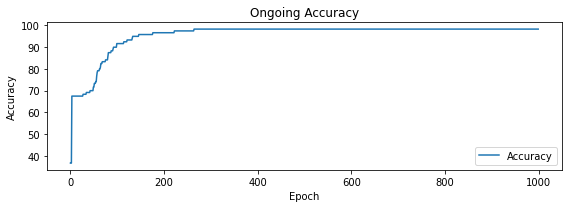

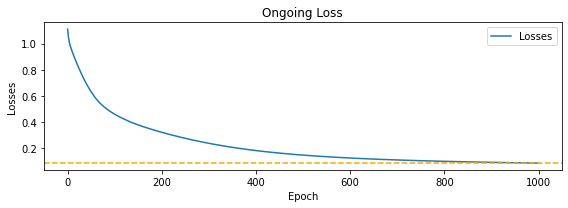

In [51]:
# normally also inspect losses and accuracy by epoch, etc etc etc.

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 3))
plt.plot(ongoingAcc, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Ongoing Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(losses.detach().cpu().numpy(), label='Losses')
plt.axhline(losses.detach().cpu().numpy()[-1],linestyle='dashed',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.title('Ongoing Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Additional explorations

In [ ]:
# 1) Randomly assigning data samples to be in the train vs test phase produced a statistical balance, but it was 
#    not perfect. Write an algorithm that will guarantee a balance of flower types while also randomly assigning
#    samples to be in train vs. test.
# 
# 2) Revert the code to its original form -- with the strong imbalance in flower types. Then train the model. What are
#    the train and test accuracies? Compute the accuracy separately for each type of flower to see whether the model
#    learned some categories, or whether it performed equally on all three categories. Are you surprised at the results? 
# 